<a href="https://colab.research.google.com/github/fAikoH-dot/TCC-v1/blob/main/prophet/prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# !pip install prophet

In [9]:
# !pip install python-bcb

In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error

C:\Users\hamatsu\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('../../data library/Milho_v1.csv', sep=";")
df = df.sort_values(by='Data').reset_index(drop=True)
df.rename(columns={"Data":"ds", "Estadual":"y"}, inplace=True)
df.head()

,ds,Cultivo,y,País,Id,Último,Abertura,Máxima,Mínima
0,2004-03-01,Milho,16.9936,17.5722,1,32025.0,32500.0,34200.0,30300.0
1,2004-04-01,Milho,19.8861,19.4868,1,29975.0,32125.0,32650.0,28175.0
2,2004-05-01,Milho,19.7989,20.2459,1,26250.0,30500.0,32250.0,26000.0
3,2004-06-01,Milho,17.9299,19.0091,1,22550.0,26250.0,26425.0,22500.0
4,2004-07-01,Milho,16.4940,17.7122,1,23775.0,22550.0,24525.0,22500.0


In [3]:
from bcb import PTAX
from bcb import currency

ptax = PTAX()

df_usd = currency.get(['USD'],
                  start='2004-03-01',
                  end='2024-09-01',
                  side='ask')

df_usd["Date"]=df_usd.index
df_usd["Month"] = df_usd["Date"].dt.month
df_usd["Year"] = df_usd["Date"].dt.year
df_usd["Day"] = 1
df_usd["Aux"] = df_usd["Year"].astype(str) +"-"+ df_usd["Month"].astype(str)
df_usd = df_usd.groupby("Aux").agg(
    USD = ("USD", "mean"),
    day = ("Day", "first"),
    month = ("Month", "first"),
    year = ("Year", "first"),
).reset_index(drop=True)

df_usd["Data"] = pd.to_datetime(df_usd[['year', 'month', 'day']])
df_usd = df_usd[["Data", "USD"]].sort_values(by="Data").reset_index(drop=True)

In [4]:
clima = pd.read_csv("../../data library/Clima/MT_dados.csv", sep=';')
clima.rename(columns={"PRECIPITACAO TOTAL":"precipitacao", "TEMPERATURA MEDIA":"temperatura"}, inplace=True)

clima["precipitacao"] = clima.precipitacao.str.replace(',', '.')
clima["temperatura"] = clima.temperatura.str.replace(',', '.')

clima.bfill(inplace=True)
clima.head()

,Data Medicao,precipitacao,temperatura
0,31/03/2004,175.4,24.9
1,30/04/2004,175.4,24.5
2,31/05/2004,23,21.7
3,30/06/2004,18.8,22.1
4,31/07/2004,38,22.2


In [5]:
df["USD"] = df_usd["USD"]
df["Precipitacao"] = clima["precipitacao"].astype(float)
df["Temperatura"] = clima["temperatura"].astype(float)
df['lag_Estadual'] = df['y'].shift(1)
df['lag_Estadual'] = df['lag_Estadual'].bfill()
df.head()

,ds,Cultivo,y,País,Id,Último,Abertura,Máxima,Mínima,USD,Precipitacao,Temperatura,lag_Estadual
0,2004-03-01,Milho,16.9936,17.5722,1,32025.0,32500.0,34200.0,30300.0,2.905457,175.4,24.9,16.9936
1,2004-04-01,Milho,19.8861,19.4868,1,29975.0,32125.0,32650.0,28175.0,2.905985,175.4,24.5,16.9936
2,2004-05-01,Milho,19.7989,20.2459,1,26250.0,30500.0,32250.0,26000.0,3.100419,23.0,21.7,19.8861
3,2004-06-01,Milho,17.9299,19.0091,1,22550.0,26250.0,26425.0,22500.0,3.129148,18.8,22.1,19.7989
4,2004-07-01,Milho,16.4940,17.7122,1,23775.0,22550.0,24525.0,22500.0,3.036777,38.0,22.2,17.9299


In [6]:
def plot_predictions(testing_dates, y_test, prediction):
    df_test = pd.DataFrame({"date": testing_dates, "actual": y_test, "prediction": prediction })
    _, ax = plt.subplots(figsize=(10, 5))
    df_test.plot(ax=ax, label="Actual", x="date", y="actual")
    df_test.plot(ax=ax, label="Prediction", x="date", y="prediction")
    plt.legend(["Actual", "Prediction"])
    plt.show()

In [7]:
def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"RMSE: {root_mean_squared_error(y_test, prediction)}")
  print(f"MAPE: {mean_absolute_percentage_error(y_test, prediction)}")
  print(f"R-Squared: {r2_score(y_test, prediction)}")

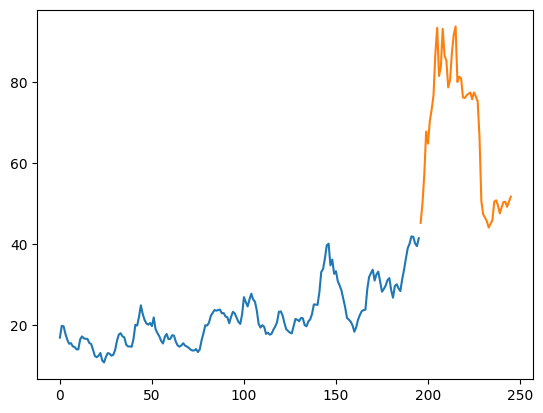

In [8]:
train_size = int(len(df) * 0.8)
train, test = df[0:train_size], df[train_size:len(df)]

test_dates = test.ds

plt.plot(train.y)
plt.plot(test.y)

# Univariado

In [18]:
m = Prophet()
m.fit(train)

# m.params

21:29:11 - cmdstanpy - INFO - Chain [1] start processing
21:29:11 - cmdstanpy - INFO - Chain [1] done processing


In [19]:
forecast = m.predict(test)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2020-08-01,32.820704,27.814003,38.013517
1,2020-09-01,33.057574,27.853267,38.485226
2,2020-10-01,33.678613,28.314399,38.917072
3,2020-11-01,34.231653,28.666646,39.220585
4,2020-12-01,34.677746,29.260347,39.355862


In [20]:
test.reset_index(inplace=True, drop=True)
final_df = test[["ds", "y"]].copy()
final_df['yhat'] = forecast['yhat']
final_df.head()

,ds,y,yhat
0,2020-08-01,45.2704,32.820704
1,2020-09-01,50.0149,33.057574
2,2020-10-01,57.2360,33.678613
3,2020-11-01,67.7848,34.231653
4,2020-12-01,64.7903,34.677746


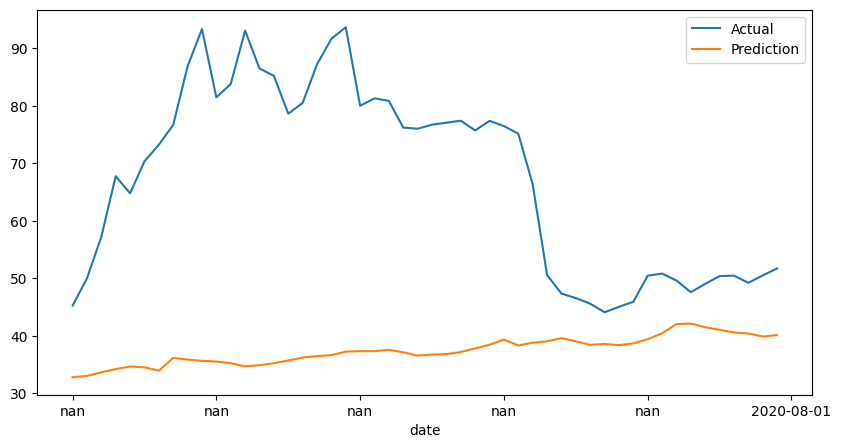

MAE: 29.951625112634886
RMSE: 34.741628763565444
MAPE: 0.40344711208503226
R-Squared: -3.5438804314488452


In [21]:
plot_predictions(test_dates, final_df.y, final_df.yhat)
evaluate_model(final_df.y, final_df.yhat)

# Multivariado

In [11]:
m = Prophet()
m.add_regressor('USD')
m.add_regressor('País')
m.add_regressor('Último')
m.add_regressor('Máxima')
m.add_regressor('lag_Estadual')
m.fit(train)

# m.params

00:20:23 - cmdstanpy - INFO - Chain [1] start processing
00:20:23 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
test_1 = test[['ds', 'USD', 'País', 'Último', 'Máxima', 'lag_Estadual']]
test_1.head()

,ds,USD,País,Último,Máxima,lag_Estadual
196,2020-08-01,5.280191,45.8405,34850.0,35300.0,41.5048
197,2020-09-01,5.461233,51.5842,37900.0,38275.0,45.2704
198,2020-10-01,5.399486,60.4194,39850.0,42225.0,50.0149
199,2020-11-01,5.625790,72.0206,41975.0,43050.0,57.2360
200,2020-12-01,5.417835,69.2060,48400.0,48575.0,67.7848


In [24]:
# future = m.make_future_dataframe(periods=len(test_1), freq='MS')
# future.head()

In [13]:
forecast = m.predict(test_1)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2020-08-01,43.898755,42.878800,44.913168
1,2020-09-01,48.638258,47.556192,49.731368
2,2020-10-01,56.224268,55.170889,57.196967
3,2020-11-01,66.381662,65.330209,67.411775
4,2020-12-01,64.355238,63.315487,65.405248


In [14]:
test.reset_index(inplace=True, drop=True)
final_df = test[["ds", "y", "País", "USD"]].copy()
final_df['yhat'] = forecast['yhat']
final_df.head()

,ds,y,País,USD,yhat
0,2020-08-01,45.2704,45.8405,5.280191,43.898755
1,2020-09-01,50.0149,51.5842,5.461233,48.638258
2,2020-10-01,57.2360,60.4194,5.399486,56.224268
3,2020-11-01,67.7848,72.0206,5.625790,66.381662
4,2020-12-01,64.7903,69.2060,5.417835,64.355238


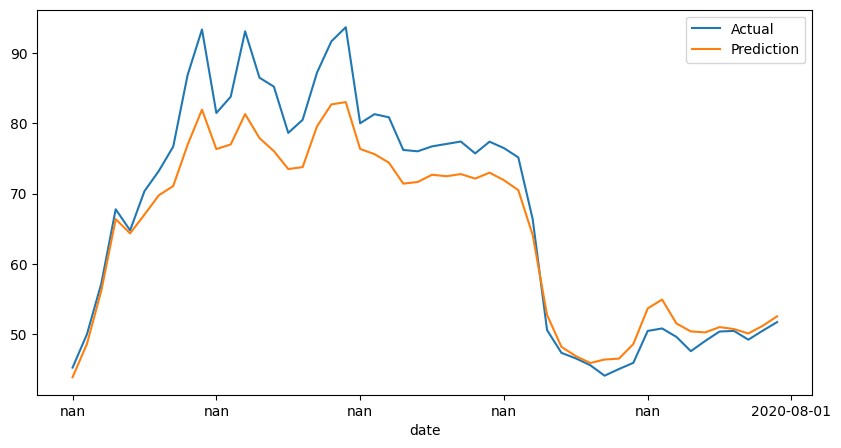

MAE: 4.084164893567509
RMSE: 5.1255908538767345
MAPE: 0.054579883229353546
R-Squared: 0.9010958724602306


In [15]:
plot_predictions(test_dates, final_df.y, final_df.yhat)
evaluate_model(final_df.y, final_df.yhat)

## Predict variables

In [16]:
aux_var = ['USD', 'País', 'Último', 'Máxima', 'lag_Estadual']
future_dates = m.make_future_dataframe(periods=((len(test_1))+24), freq="MS")

In [17]:
extended_df = future_dates.copy()

for i in aux_var:
    train_aux = train[['ds', i]].copy()
    train_aux.rename(columns={i:"y"}, inplace=True)

    m = Prophet()
    m.fit(train_aux)
    forecast = m.predict(future_dates)
    
    extended_df[i] = forecast["yhat"]

extended_df

00:20:43 - cmdstanpy - INFO - Chain [1] start processing
00:20:43 - cmdstanpy - INFO - Chain [1] done processing
00:20:44 - cmdstanpy - INFO - Chain [1] start processing
00:20:44 - cmdstanpy - INFO - Chain [1] done processing
00:20:44 - cmdstanpy - INFO - Chain [1] start processing
00:20:44 - cmdstanpy - INFO - Chain [1] done processing
00:20:44 - cmdstanpy - INFO - Chain [1] start processing
00:20:44 - cmdstanpy - INFO - Chain [1] done processing
00:20:45 - cmdstanpy - INFO - Chain [1] start processing
00:20:45 - cmdstanpy - INFO - Chain [1] done processing


,ds,USD,País,Último,Máxima,lag_Estadual
0,2004-03-01,2.814078,16.152117,25683.304218,27237.786010,14.861895
1,2004-04-01,2.785586,15.764326,25357.933356,26226.675332,14.781420
2,2004-05-01,2.809846,15.332740,24367.329239,26676.600334,14.514824
3,2004-06-01,2.843009,14.945879,24818.182304,27957.934388,14.340675
4,2004-07-01,2.775656,14.539473,24278.248230,29170.257897,14.216930
...,...,...,...,...,...,...
265,2026-05-01,6.227675,45.146277,11570.605071,12141.437195,43.695452
266,2026-06-01,6.277252,45.035057,10396.825427,12841.270802,43.570545
267,2026-07-01,6.269313,44.618177,8966.798865,12023.438364,43.618643
268,2026-08-01,6.228821,44.290333,7895.912510,8704.619836,42.753488


In [19]:
extended_df.to_csv("expanded_df_milho.csv", sep = ";", index=False)

## Final results

In [60]:
m = Prophet()
m.add_regressor('USD')
m.add_regressor('País')
m.add_regressor('Último')
m.add_regressor('Máxima')
m.add_regressor('lag_Estadual')
m.fit(train)

22:01:28 - cmdstanpy - INFO - Chain [1] start processing
22:01:28 - cmdstanpy - INFO - Chain [1] done processing


In [89]:
real_data = df[['ds', 'USD', 'País', 'Último', 'Máxima', 'lag_Estadual']].copy()
final_date = df["ds"][-1:]
predicted_data = extended_df[['ds', 'USD', 'País', 'Último', 'Máxima', 'lag_Estadual']][len(train)+len(test):]

real_data_2 = pd.concat([real_data, predicted_data], ignore_index=True)

In [90]:
test_2 = real_data_2[['ds', 'USD', 'País', 'Último', 'Máxima', 'lag_Estadual']][train_size:].reset_index(drop=True)
test_2.head()

,ds,USD,País,Último,Máxima,lag_Estadual
0,2020-08-01,5.280191,45.8405,34850.0,35300.0,41.5048
1,2020-09-01,5.461233,51.5842,37900.0,38275.0,45.2704
2,2020-10-01,5.399486,60.4194,39850.0,42225.0,50.0149
3,2020-11-01,5.625790,72.0206,41975.0,43050.0,57.2360
4,2020-12-01,5.417835,69.2060,48400.0,48575.0,67.7848


In [91]:
final_forecast = m.predict(test_2)
final_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2020-08-01,43.898755,42.909000,44.963901
1,2020-09-01,48.638258,47.591499,49.760989
2,2020-10-01,56.224268,55.189619,57.180096
3,2020-11-01,66.381662,65.363735,67.403980
4,2020-12-01,64.355238,63.310000,65.338544


In [97]:
test_2.reset_index(inplace=True, drop=True)
test_2['y'] = test['y']
test_2.fillna(0, inplace=True)
final_df = test_2[["ds", "y", "País", "USD"]].copy()
final_df['yhat'] = final_forecast['yhat']
final_df.head()

,ds,y,País,USD,yhat
0,2020-08-01,45.2704,45.8405,5.280191,43.898755
1,2020-09-01,50.0149,51.5842,5.461233,48.638258
2,2020-10-01,57.2360,60.4194,5.399486,56.224268
3,2020-11-01,67.7848,72.0206,5.625790,66.381662
4,2020-12-01,64.7903,69.2060,5.417835,64.355238


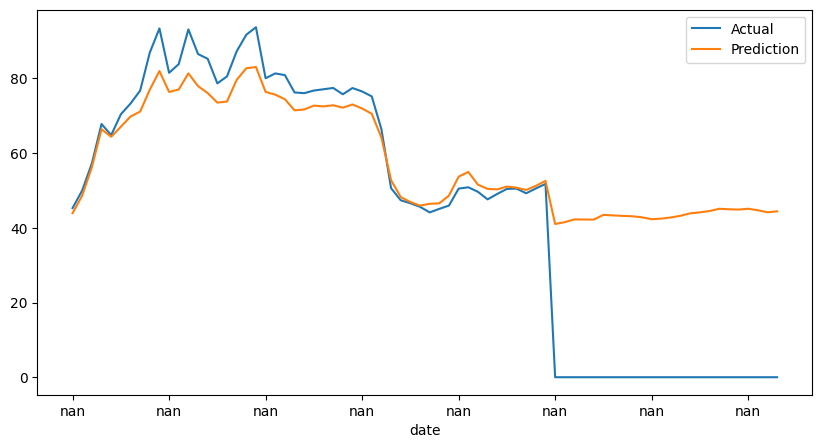

MAE: 16.833611978148394
RMSE: 25.078396149411727
MAPE: 6.338384627209516e+16
R-Squared: 0.46463695634808433


In [98]:
plot_predictions(test_dates, final_df.y, final_df.yhat)
evaluate_model(final_df.y, final_df.yhat)

In [101]:
final_df.to_csv('../../Milho/Milho_Resultados.csv', sep=',', index=False)